# Exercises Week 9 in 02506: Developing a Neural Network for MNIST 

The dataset can be downloaded [as .gz files here](http://yann.lecun.com/exdb/mnist/).

<p align="center"> 
  <img src="../MNIST/raw/MNIST_images_train/image_train_00000.png" width="300" title="Very simple NN">
</p>

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import cv2
from skimage.io import imshow
import random

# For confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Pre-processing of MNIST Data

In [2]:
img_path = '../MNIST/'
raw_path = 'raw/MNIST_images_train/'
processed_path = 'processed/'
files = listdir(img_path+raw_path)
print(f"There are {np.size(files)} images")

There are 60000 images


### Loading, Transforming and Storing the Data

In [3]:
def transform(img):
    img = img.flatten() / 255.0
    img -= np.mean(img)
    img /= np.linalg.norm(img,2)
    return np.float32(np.reshape(img,[784,1]))

import os
if len(listdir(img_path+processed_path)) == 0:
    print("Directory is empty. Generating data")
    images = [transform(cv2.imread(img_path+raw_path+file, cv2.IMREAD_GRAYSCALE)) for file in files]
    labels_tmp = np.load(img_path+'raw/MNIST_target_train.npy')
    labels = []
    for i in range(np.size(labels_tmp)):
        lab = np.zeros([10,1]).astype(int)
        lab[labels_tmp[i]] = 1
        labels.append(lab)

    # Splitting into train and test sets
    print(np.array(images).shape)
    n = np.size(files)
    n_test = 10000
    l = np.arange(0,n).astype(int)
    random.shuffle(l) 
    idx_split = n-n_test;
    idx_train = l[0:idx_split].astype(int)
    idx_test =  l[idx_split-1:n-1].astype(int)
    images = np.array(images)
    np.save(img_path+processed_path+'train_images.npy', images[idx_train], allow_pickle=True, fix_imports=True)
    np.save(img_path+processed_path+'test_images.npy', images[idx_test], allow_pickle=True, fix_imports=True)
    np.save(img_path+processed_path+'train_labels.npy', labels[idx_train], allow_pickle=True, fix_imports=True)
    np.save(img_path+processed_path+'test_labels.npy', labels[idx_test], allow_pickle=True, fix_imports=True)
else:    
    print("Preprocessed data already exists")
    img_train = np.load(img_path+processed_path+'train_images.npy')
    img_test = np.load(img_path+processed_path+'test_images.npy')
    label_train = np.load(img_path+processed_path+'train_labels.npy')
    label_test = np.load(img_path+processed_path+'test_labels.npy')

Preprocessed data already exists


In [4]:
print(np.load(img_path+processed_path+'train_labels.npy').shape)

(50000, 10, 1)


### Making Mini-batches

In [5]:
def make_batches(images,labels,batch_size=20):
    M = np.shape(images)[0]
    res = []
    num_batches = np.ceil(M/batch_size).astype(int)
    for i in range(num_batches-1):
        imgs = np.hstack(images[i*batch_size:(i+1)*batch_size])
        labs = np.hstack(labels[i*batch_size:(i+1)*batch_size])
        res.append((imgs,labs))
    return res

bath_size = 20
batches_test = make_batches(img_test,label_test,batch_size=bath_size)
batches_train = make_batches(img_train,label_train,batch_size=bath_size)

### Example of Transformed Data

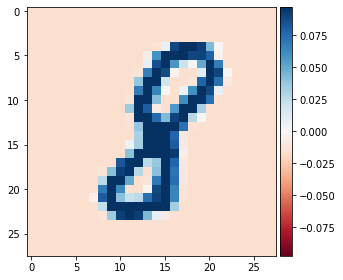

In [6]:
imshow(np.reshape(img_train[0],[28,28]))

### Activation Function
Before we move on to make a neural network we have do define our activation functions and their derivatives

In [7]:
def ReLU(z):
    zbar = np.zeros(z.shape)
    idx = z > 0
    zbar[idx] = z[idx]
    return zbar

def dReLU(z):
    idx = z > 0
    return idx.astype(float)

def Sigmoid(z):
    return 1/(1+np.exp(-z))

def Softmax(z):
    # Avoiding numerical instability
    col_max = np.max(z, axis=0)
    z -= col_max
    expz = np.exp(z)
    col_sum = np.sum(expz, axis=0)
    ret = expz/col_sum
    return ret

def dSoftmax(z):
    S = Softmax(z)
    rows,cols = np.shape(S)
    ret = np.hstack([np.sum(np.diagflat(S[:,i]) - np.dot(S[:,i], S[:,i].T),axis=1)[:,None] for i in range(cols)])
    return ret

z = np.random.normal(0,1,size=(3,2))
print(f"z={z}")
print(f"ReLU(z)={ReLU(z)}")
print(f"dReLU(z)={dReLU(z)}")
print(f"Sigmoid(z)={Sigmoid(z)}")
print(f"Softmax(z)={Softmax(z)}")
print(f"dSoftmax(z)={dSoftmax(z)}")

z=[[ 0.12740671 -0.94236642]
 [ 0.1098918   0.19179009]
 [-2.14192263  0.9148732 ]]
ReLU(z)=[[0.12740671 0.        ]
 [0.1098918  0.19179009]
 [0.         0.9148732 ]]
dReLU(z)=[[1. 0.]
 [1. 1.]
 [0. 1.]]
Sigmoid(z)=[[0.53180866 0.28042259]
 [0.52744534 0.54780109]
 [0.10508844 0.71399633]]
Softmax(z)=[[0.479382   0.09510604]
 [0.47105877 0.29564191]
 [0.04955923 0.60925205]]
dSoftmax(z)=[[-0.88309676 -1.30780605]
 [-0.89141999 -1.10727017]
 [-1.31291954 -0.79366003]]


### Initializing Arrays

In [8]:
def init(rows,cols=1):
    z = np.random.normal(0,1,size=(rows,cols))
    return np.sqrt(2/(rows))*z

print(f"init(4,2)={init(4,2)}")

init(4,2)=[[ 0.5295225  -0.3830954 ]
 [ 0.02685914  0.00191059]
 [-0.07074395  0.92357839]
 [-0.00328305  0.54887318]]


### Defining a Linear Layer
We will now implement a linear layer that supports dropout. That is, it randomly removes the contributions from some connections in the linear layer during the forward pass.

In [66]:
class LinearLayer:
    def __init__(self,N_in,N_out,prob=0.0):
        self.weights = init(N_out,N_in+1)
        self.N_in = N_in
        self.N_out = N_out
        self.prob = prob
    
    def dropout(self,x):
        mask = np.random.uniform(size=np.shape(x)) <= self.prob
        x[mask] = 0
        return x

    def forward(self,X,train=True):
        res = self.weights@np.vstack((X,np.ones([1,np.shape(X)[1]])))
        if self.prob > 0 and train:
            return self.dropout(res)
        return res

LL1 = LinearLayer(3,4,prob=0.1)
X = np.random.normal(-1,1,size=(3,4))
Y = LL1.forward(X)
print(f"forward({X})\n={Y}")

forward([[-0.7802668   0.02491309  0.62058277 -1.75409169]
 [-0.99662821 -0.56778595 -0.53270121 -1.59130295]
 [-0.63400378 -0.73528526 -1.08466657 -1.47858057]])
=[[0.         0.92501866 0.99451164 3.23861823]
 [0.38025866 0.22965127 0.5704293  0.747775  ]
 [2.36433924 0.         0.24495754 3.83170511]
 [0.         0.38323859 0.         1.12944762]]


### Defining Cross Entropy Loss


In [67]:
def argmax(Y):
    Ytmp = np.array(Y).argmax(axis=0)
    Y = np.array([Y[:,i] == Y[Ytmp[i],i] for i in range(np.size(Ytmp))]).T
    return Y
    #return z.a.argmax(axis=0)
    
def CrossEntropyLoss(Y,T):
    Y = Y.flatten()
    T = T.flatten()
    return np.sum(-np.log(Y[T>0]+0.0000001))/np.sum(T)

T = argmax(Y)
print(f"CrossEntropyLoss(Y,T)={CrossEntropyLoss(Y,T)}")

CrossEntropyLoss(Y,T)=-0.5300909816353991


### Defining Accuracy

In [68]:
def accuracy(y,t):
    M,N = np.shape(y)
    y = np.argmax(y,axis=0)
    t = np.argmax(t,axis=0)
    return  np.sum(y == t)/N

### Defining A Neural Network Class

In [74]:
class NeuralNetwork:
    def __init__(self,shapes,act_funs,diff_act_funs,seed = 1234,dropout=0.0):
        np.random.seed(seed)
        self.layers = []
        self.act_funs = act_funs
        self.diff_act_funs = diff_act_funs
        self.length = np.size(act_funs)
        assert(self.length == np.size(shapes)-1)
        self.h = []
        self.h.append([])
        self.a = []
        for i in range(self.length):
            self.layers.append(LinearLayer(shapes[i],shapes[i+1],prob=dropout))
        self.init_grads(shapes)
        self.train_bool = True

    def init_grads(self,shapes):
        for i in range(self.length):
            self.h.append(np.zeros([]))
            self.a.append(np.zeros([]))
    
    def zero_grads(self):
        self.h[0] = np.zeros(self.h[0].shape)
        for i in range(self.length):
            self.h[i+1] = np.zeros(self.h[i+1].shape)
            self.a[i] = np.zeros(self.a[i].shape)
    
    def forward(self,X):
        self.h[0] = X
        for i in range(self.length):
            X = self.layers[i].forward(X,train=self.train_bool)
            if self.train:
                self.h[i+1] = X
                self.a[i] = self.diff_act_funs[i](X)
            X = self.act_funs[i](X)
        return X

    def backward(self,Y,T,L,lr=0.01):
        d = Y-np.float32(T)
        h = []
        for i,hi in enumerate(self.h):
            h.append(np.vstack((hi,np.ones([1,np.shape(hi)[1]]))))
        W = []
        for i,layer in enumerate(self.layers):
            wi = layer.weights
            #print(f"w{i}={wi}")
            W.append(wi[:,:-1])
        for i in range(self.length-1,-1,-1):
            Q = h[i]@d.T
            Q /= np.shape(T)[1]
            if i>0:
                d = np.multiply(self.a[i-1],W[i].T@d)
            # Updating weights
            self.layers[i].weights -= lr*Q.T
            #print(i)
        
        #for i,layer in enumerate(self.layers):
            #wi = layer.weights
            #print(f"w{i}={wi}")
        self.zero_grads()

    def train(self):
        self.train_bool = True

    def eval(self):
        self.train_bool = False
        self.zero_grads()

X,T = batches_train[0]
NN = NeuralNetwork([784,999,299,10],[ReLU,ReLU,Softmax],[dReLU,dReLU,dReLU])
Y = NN.forward(X)
L = CrossEntropyLoss(Y,T)
NN.backward(Y,T,L)
print(f"NN(X)\n={Y}")
print(accuracy(Y,T))

NN(X)
=[[0.05699141 0.07060001 0.09185873 0.05778886 0.10397362 0.03723531
  0.12642696 0.0506133  0.1079732  0.1057151  0.08875705 0.08667357
  0.06575804 0.0836954  0.05311516 0.10498198 0.07579047 0.0689841
  0.10567771 0.05373376]
 [0.02833635 0.03098469 0.02656457 0.02125362 0.01935052 0.04796147
  0.02404272 0.04235674 0.02355576 0.03267279 0.01850016 0.02752509
  0.01482372 0.02869903 0.02310147 0.02902489 0.02920476 0.02223692
  0.01418409 0.04112593]
 [0.0352317  0.09110745 0.07571691 0.11508177 0.04128497 0.06995315
  0.06700103 0.05416356 0.06870801 0.08383173 0.05707935 0.0599572
  0.03551781 0.06154602 0.06620037 0.06720604 0.17020971 0.06437346
  0.0648715  0.06140957]
 [0.01951836 0.03915864 0.02964296 0.01741225 0.0191003  0.03203485
  0.02281085 0.02190999 0.04615223 0.03871541 0.01839582 0.02932595
  0.01678161 0.02416723 0.01267086 0.02889131 0.05562567 0.02520626
  0.0243705  0.03223764]
 [0.06632138 0.07165983 0.0615663  0.05888918 0.06248075 0.07194125
  0.0449460

### Training

In [78]:
NN = NeuralNetwork([784,999,299,10],[ReLU,ReLU,Softmax],[dReLU,dReLU,dSoftmax],dropout=0.4)

train_loss = []
val_loss = []
train_acc = []
val_acc = []

epochs = 50
lr = 0.00008

N_train = 1000 #np.size(batches_train)
N_test = 100 #np.shape(batches_test)

for e in range(epochs):
    train_l = 0
    train_a = 0
    NN.train()
    for i in range(N_train):
        x,t = batches_train[i]
        y = NN.forward(x)
        t = t.astype(bool)
        l = CrossEntropyLoss(y,t)
        NN.backward(y,t,l,lr=lr)
        train_l += l
        train_a += accuracy(y,t)
    train_loss.append(train_l/N_train)
    train_acc.append(train_a/N_train)
    val_l = 0
    val_a = 0
    NN.eval()
    for i in range(N_test):
        x,t  = batches_test[i]
        y = NN.forward(x)
        t = t.astype(bool)
        l = CrossEntropyLoss(y,t)
        val_l += l
        val_a += accuracy(y,t)
    val_loss.append(val_l/N_test)
    val_acc.append(val_a/N_test)

### Evaluating Results

In [83]:
print(f"Final accuracy:\n\tTraining: {train_acc[epochs-1]}\n\tValidation: {val_acc[epochs-1]}")
print(f"Final cross entropy loss :\n\tTraining: {train_loss[epochs-1]}\n\tValidation: {val_loss[epochs-1]}")

Final accuracy:
	Training: 0.6515
	Validation: 0.8329999999999999
Final cross entropy loss :
	Training: 1.0504163045507877
	Validation: 0.5299572790980281


<bound method Figure.show of <Figure size 864x288 with 2 Axes>>

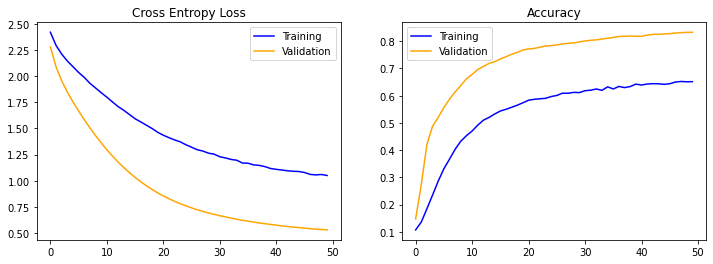

In [79]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(range(0,epochs),train_loss,c = 'blue',label='Training')
ax1.plot(range(0,epochs),val_loss,c = 'orange',label='Validation')
ax1.legend()
ax1.set_title("Cross Entropy Loss")
ax2.plot(range(0,epochs),train_acc,c = 'blue',label='Training')
ax2.plot(range(0,epochs),val_acc,c = 'orange',label='Validation')
ax2.legend()
ax2.set_title("Accuracy")
fig.show

### Evaluating the Network Classifications
To verify that the network did indeed compute the right thing, we will try to see how well it predicts the classes of the testset.

In [80]:
counter = 0

predicted_img = None
predicted_lab = None
true_lab = None

for i in range(N_test):
    x,t  = batches_test[i]
    y = NN.forward(x)
    t = t.astype(bool)
    l = CrossEntropyLoss(y,t)
    val_l += l
    len, n_im = np.shape(x)
    if i > 0:
        predicted_img = np.hstack((predicted_img,x))
        predicted_lab = np.hstack((predicted_lab,y))
        true_lab = np.hstack((true_lab,t))
    else: 
        predicted_img = x
        predicted_lab = y
        true_lab = t
NN.zero_grads()

predicted_lab = np.argmax(predicted_lab,axis=0)
true_lab = np.argmax(true_lab,axis=0)

We can draw a few random images from the tests set and see, if they have been predicted correctly.

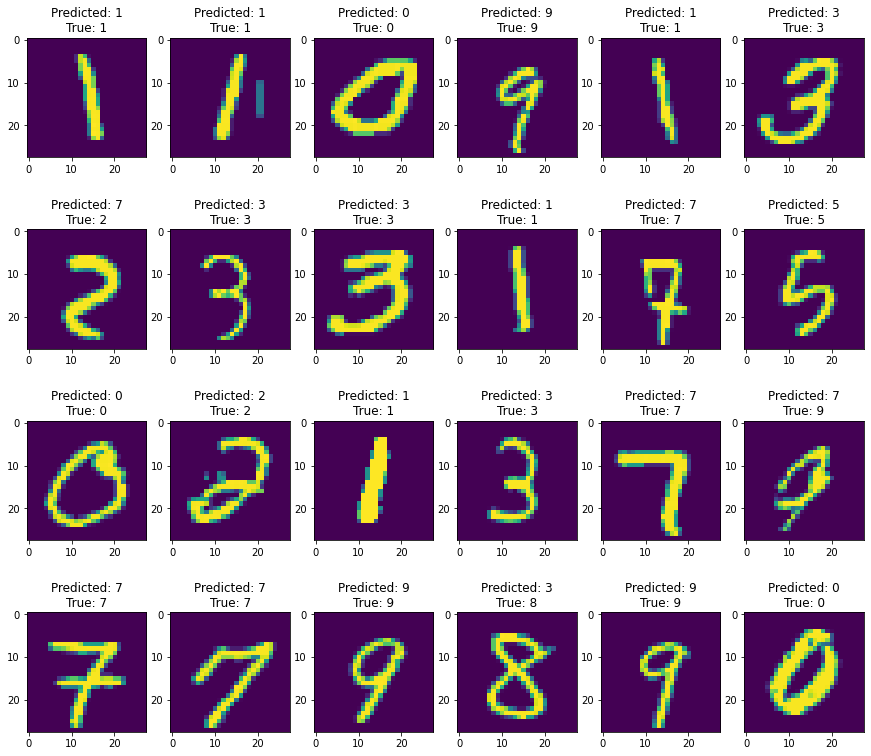

In [81]:
m = 4
n = 6

fig, ax = plt.subplots(m,n,figsize=(3.75*m,2.25*n))

for i in range(m):
    for j in range(n):
        idx = i*n+j
        ax[i][j].imshow(np.reshape(predicted_img[:,idx],[28,28]))
        ax[i][j].set_title(f"Predicted: {predicted_lab[idx]}\nTrue: {true_lab[idx]}")

### Confusion Matrix
Overall the predictions seemed right. We can get an ideay about how good the predictions are by inspecting the confusion matrix.

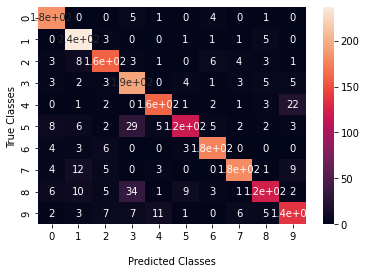

In [82]:
conf_mat = confusion_matrix(true_lab, predicted_lab)
ax = sns.heatmap(conf_mat, annot=True)
ax.set_xlabel('\nPredicted Classes')
ax.set_ylabel('True Classes ');

## Display the visualization of the Confusion Matrix.
plt.show()